<a href="https://colab.research.google.com/github/rahulsm27/Colab_practicse/blob/main/Dehaze_orignal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = '/content/drive/MyDrive/Haze_dehaze/Dataset.zip'
# Destination directory where the contents will be extracted
destination_dir = '/content/drive/MyDrive/Haze_dehaze/'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Unzipping completed.")


Unzipping completed.


In [4]:
import os
import glob

def print_image_names(orig_img_path, hazy_img_path):
    orig_img_names = glob.glob(orig_img_path + '/*.jpg')
    hazy_img_names = glob.glob(hazy_img_path + '/*.jpg')

    print("First 5 original image names:")
    for img_path in orig_img_names[:5]:
        print(os.path.basename(img_path))

    print("\nFirst 5 hazy image names:")
    for img_path in hazy_img_names[:5]:
        print(os.path.basename(img_path))

# orig_img_path = '/content/drive/MyDrive/Haze_dehaze/Dataset/Train/GT'
# hazy_img_path = '/content/drive/MyDrive/Haze_dehaze/Dataset/Train/hazy'

orig_img_path ='/content/drive/MyDrive/haze/Dataset-Haze/DS4/GT'
hazy_img_path = '/content/drive/MyDrive/haze/Dataset-Haze/DS4/hazy'

print_image_names(orig_img_path, hazy_img_path)


First 5 original image names:
36_outdoor_GT.jpg
37_outdoor_GT.jpg
11_outdoor_GT.jpg
12_outdoor_GT.jpg
38_outdoor_GT.jpg

First 5 hazy image names:
36_outdoor_hazy.jpg
37_outdoor_hazy.jpg
11_outdoor_hazy.jpg
12_outdoor_hazy.jpg
38_outdoor_hazy.jpg


Prepared 38 training pairs and 5 validation pairs
Train data path example: /content/drive/MyDrive/haze/Dataset-Haze/DS4/hazy/36_outdoor_hazy.jpg, type: <class 'str'>
Validation data path example: /content/drive/MyDrive/haze/Dataset-Haze/DS4/hazy/11_outdoor_hazy.jpg, type: <class 'str'>

Start of epoch 0 [=]  -  Training Loss: 0.8239

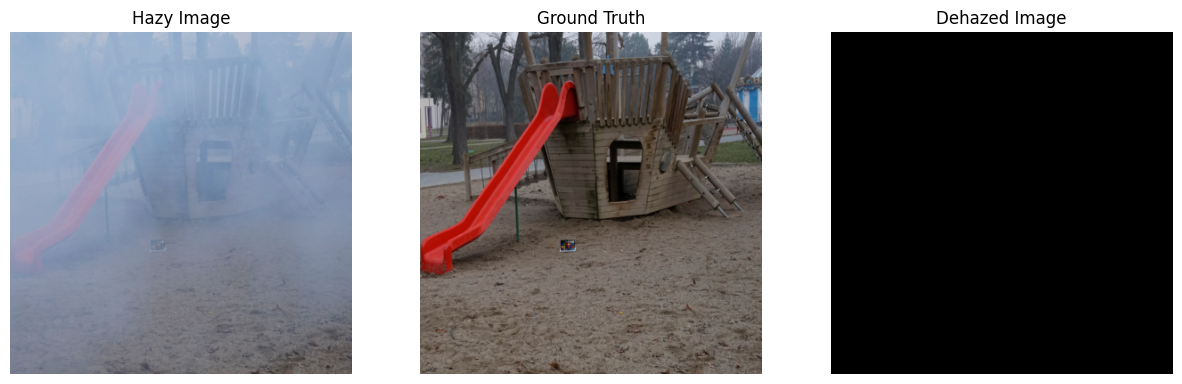

  -  Validation Loss: 0.8836  -   Time taken: 26.35s


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(



Start of epoch 1 [=]  -  Training Loss: 0.7971

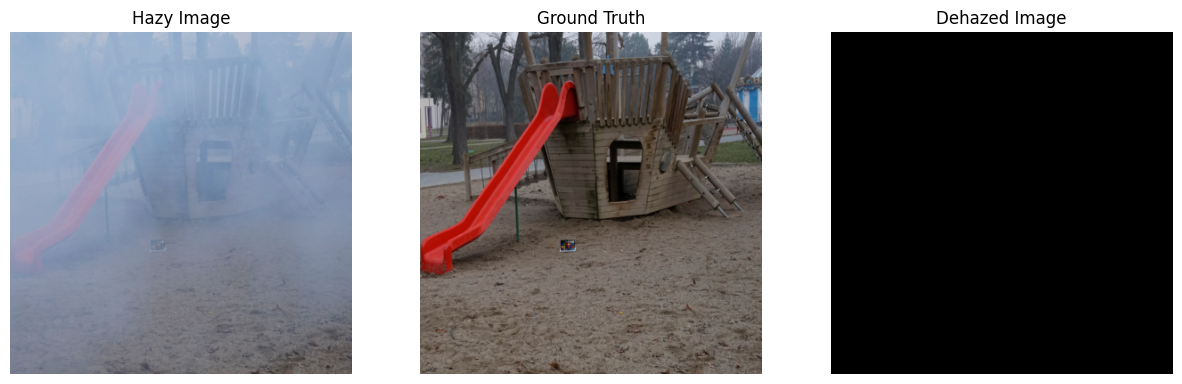

  -  Validation Loss: 0.8375  -   Time taken: 22.13s


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(



Start of epoch 2 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image
import time
import datetime, zipfile
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

# Preprocessing and loading of data
def load_image(img_path):
    img = tf.io.read_file(img_path) # returns string
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (384, 384), antialias = True)
    img = img / 255.0
    return img

import os

def data_path(orig_img_path, hazy_img_path):
    train_img = []
    val_img = []
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]
    val_keys = orig_img[int(0.9*n):]
    split_dict = {os.path.basename(path): 'train' for path in train_keys}
    split_dict.update({os.path.basename(path): 'val' for path in val_keys})

    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = os.path.basename(img)
        orig_file_name = img_name.replace('_hazy', '_GT')  # Transform hazy image name to original image name
        if orig_file_name in split_dict:
            orig_path = os.path.join(orig_img_path, orig_file_name)
            if split_dict[orig_file_name] == 'train':
                train_img.append([img, orig_path])
            else:
                val_img.append([img, orig_path])

    print(f"Prepared {len(train_img)} training pairs and {len(val_img)} validation pairs")
    return train_img, val_img


# Function to load tensor image data in batches.
def dataloader(train_data, val_data, batch_size):
    # Debug print to check the data type of the first path in train_data and val_data
    print(f"Train data path example: {train_data[0][0]}, type: {type(train_data[0][0])}")
    print(f"Validation data path example: {val_data[0][0]}, type: {type(val_data[0][0])}")

    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(load_image)
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(load_image)
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)

    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(load_image)
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(load_image)
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)

    return train, val

# Function to display output.
def display_img(model, hazy_img, orig_img):
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,12))
    display_list = [hazy_img[0], orig_img[0], (hazy_img[0]-dehazed_img[0])*255]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

# Network Function
def gman_net():

    inputs = tf.keras.Input(shape = [384, 384, 3])

                                    #GMAN Network
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)

                                    #Encoding Layers
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)

                                    #Residual Layers
    conv1_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)

                                            ##### Decoding Layers #####
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    gman_output = tf.keras.activations.relu(conc)

                               ######################## Parallel Network ###########################
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                           activation = 'relu', kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                 kernel_regularizer = regularizer)(deconv)
    conc = tf.add(conv, inputs)
    pn_output = tf.keras.activations.relu(conc)

    output = tf.add(gman_output, pn_output)

    return Model(inputs = inputs, outputs = output)


#Training and validation function
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):

    for epoch in range(epochs):

        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()

        # training loop

        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_haze-train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')

        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')

        # validation loop
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_haze-val_batch_orig, val_logits)

            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)

        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))

        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

def evaluate(net, test_img_path):

    test_img = glob.glob(test_img_path + '/*.jpg')
    random.shuffle(test_img)

    for img in test_img:

        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)

        if img.shape[1] > img.shape[0]:
            img = tf.image.resize(img, size = (384, 384), antialias = True)
        if img.shape[1] < img.shape[0]:
            img = tf.image.resize(img, size = (384, 384), antialias = True)

        img = img / 255
        img = tf.expand_dims(img, axis = 0)      # transform input image from 3D to 4D

        dehaze = net(img, training = False)

        plt.figure(figsize = (80, 80))

        display_list = [img[0], dehaze[0]]
        title = ['Input Image', 'Output Image']

        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(title[i], fontsize = 65, y = 1.045)
            plt.imshow(display_list[i])
            plt.axis('off')

        plt.show()

# Hyperparameters
epochs = 10
batch_size = 4

# orig_img_path = '/content/drive/MyDrive/Haze_dehaze/Dataset/Train/GT'
# hazy_img_path = '/content/drive/MyDrive/Haze_dehaze/Dataset/Train/hazy'

k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = data_path(orig_img_path,  hazy_img_path)

train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = gman_net()

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

test_net = tf.keras.models.load_model('trained_model', compile = False)
#evaluate(test_net, 'data\\haze')
